In [33]:
import os
import glob
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd
from sublimpy import utils, extrautils
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
import act
import swifter

# Classify along-valley vs cross-valley synoptic winds using doppler lidar PPI/VAD dataset

In [34]:
USERNAME = os.getenv("ARM_USERNAME")
TOKEN = os.getenv("ARM_TOKEN")
SAIL_DATA_STREAM = 'gucdlprofwind4newsM1.c1'
DATA_STREAM_FILEEXT = '.nc'
startdate = "2022-11-30"
enddate = "2023-06-20"
output_dir = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", SAIL_DATA_STREAM)


In [35]:
# act.discovery.download_arm_data(USERNAME, TOKEN, SAIL_DATA_STREAM, startdate, enddate, output=output_dir)

In [36]:
dl_w_prof_files = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/*.nc")

In [37]:
prof_ds = act.io.read_arm_netcdf(dl_w_prof_files)
prof_ds.time.min(), prof_ds.time.max()

(<xarray.DataArray 'time' ()> Size: 8B
 array('2022-11-30T00:00:39.646250000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()> Size: 8B
 array('2023-06-15T23:59:20.789108000', dtype='datetime64[ns]'))

In [38]:
prof_df = prof_ds.to_dataframe()
prof_df = utils.modify_df_timezone(prof_df.reset_index(), 'UTC', 'US/Mountain').set_index('time')

In [39]:
hourly_mean_prof_df = prof_df.query("height > 950").query("height < 1100")[['wind_speed', 'wind_direction']].reset_index().set_index('time').groupby(pd.Grouper(freq='60min')).mean()

In [40]:
synoptic_winds_30min = hourly_mean_prof_df.resample('30min').mean().ffill()
along_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 299)
    & (synoptic_winds_30min.wind_direction < 345 )
].index.values
cross_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 202)
    & (synoptic_winds_30min.wind_direction < 248 )
].index.values
len(cross_valley_wind_times), len(along_valley_wind_times)

(2172, 1766)

In [41]:
pd.Series(cross_valley_wind_times).to_csv('cross_valley_wind_times.csv')
pd.Series(along_valley_wind_times).to_csv('along_valley_wind_times.csv')

# Prepare Surface Turbulence Measurements

In [42]:
sos_tidy_fn = f"../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10_streamwise.parquet"
tidy_df = pd.read_parquet(sos_tidy_fn)
# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# tidy_df = tidy_df[tidy_df.time > '20230301']
tidy_df = tidy_df[tidy_df.time > '20221221']
tidy_df.time.min(), tidy_df.time.max()

(Timestamp('2022-12-21 00:30:00'), Timestamp('2023-06-19 17:30:00'))

Isolate turbulence statistics

In [43]:
src = tidy_df[tidy_df.variable.isin([
    'tke_3m_c', 'spd_3m_c', 'w_h2o__3m_c', 'w_tc__3m_c', 'u_v__3m_c', 'u_w__3m_c', 'v_w__3m_c',
    'tke_20m_c', 'spd_20m_c', 'w_h2o__20m_c', 'w_tc__20m_c', 'u_v__20m_c', 'u_w__20m_c', 'v_w__20m_c',
    'spd_3m_d', 'spd_3m_uw', 'spd_3m_ue',
    'tke_3m_d', 'tke_3m_uw', 'tke_3m_ue',
])].pivot(index='time', columns='variable', values='value')
src['Vtke_3m_c'] = src['tke_3m_c']**0.5
src['Vtke_3m_d'] = src['tke_3m_d']**0.5
src['Vtke_3m_uw'] = src['tke_3m_uw']**0.5
src['Vtke_3m_ue'] = src['tke_3m_ue']**0.5
src['hourofday'] = src.index.hour

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

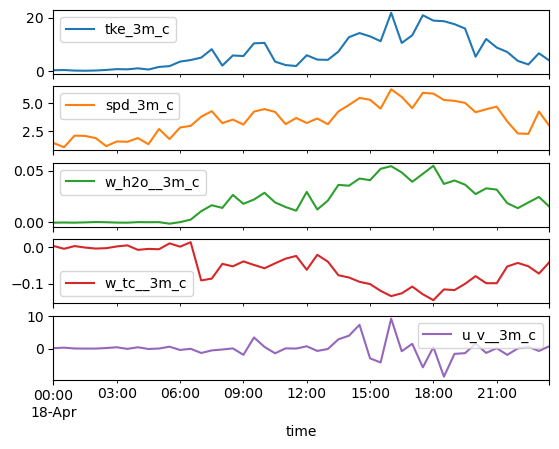

In [44]:
src.loc['20230418'][
    ['tke_3m_c', 'spd_3m_c', 'w_h2o__3m_c', 'w_tc__3m_c', 'u_v__3m_c']
].plot(subplots=True)

# Plot V_tke vs wind speed - identify top-down turbulence

In [45]:
alt.Chart(src.loc['20221222']).mark_text(color='blue').encode(
    alt.X('spd_3m_c:Q'),
    alt.Y('Vtke_3m_c:Q'),
    alt.Text('hourofday:O'),
).properties(width=200, height = 200) +\
alt.Chart(src.loc['20230418']).mark_text(color='red').encode(
    alt.X('spd_3m_c:Q'),
    alt.Y('Vtke_3m_c:Q'),
    alt.Text('hourofday:O'),
).properties(width=200, height = 200) +\
alt.Chart(src.loc['20230409']).mark_text(color='black').encode(
    alt.X('spd_3m_c:Q'),
    alt.Y('Vtke_3m_c:Q'),
    alt.Text('hourofday:O'),
).properties(width=200, height = 200) 

alt.LayerChart(...)

In [46]:
alt.Chart(
    tidy_df.query("tower == 'c'").query("measurement == 'wind speed'").set_index('time').loc['20230418'].reset_index()
).mark_line().encode(
    alt.X('mean(value):Q'),
    alt.Y('height:Q'),
    alt.Facet('hours(time):T', columns=4),
    order='height'
).properties(width=100, height=100)

alt.Chart(...)

In [47]:
base = alt.Chart().mark_text().encode(
        alt.X('spd_3m_c:Q').scale(domain=[0, 10], clamp=True),
        alt.Y('Vtke_3m_c:Q'),
        alt.Text('hourofday:O'),
        alt.Facet('date(time):T', columns=5)
    ).properties(width=200, height = 200)

(
    alt.hconcat(base, data=src.loc['20221221': '20221222'].reset_index()).resolve_scale(x='shared', y='shared') &\
    alt.hconcat(base, data=src.loc['20230218': '20230219'].reset_index()).resolve_scale(x='shared', y='shared') &\
    alt.hconcat(base, data=src.loc['20230305': '20230307'].reset_index()).resolve_scale(x='shared', y='shared') &\
    alt.hconcat(base, data=src.loc['20230418': '20230419'].reset_index()).resolve_scale(x='shared', y='shared')
).resolve_scale(x='shared', y='shared')

alt.VConcatChart(...)

In [48]:
alt.Chart(
    src.loc['20230401': '20230430'].reset_index()
).mark_text().encode(
    alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True),
    alt.Y('Vtke_3m_c:Q'),
    alt.Text('hourofday'),
    # alt.Color('hourofday:Q').scale(scheme='rainbow'),
    alt.Facet('date(time)', columns=5)
).properties(width=200, height = 200)

alt.Chart(...)

In [49]:
base = alt.Chart(pd.concat([
        src.loc['20230409'].reset_index(),
        src.loc['20230418'].reset_index()
])).mark_circle().encode(    
    alt.Color('date(time):N'),
).properties(width=200, height = 200)

(base.encode(
    alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True), alt.Y('Vtke_3m_c'),
) | base.encode(
    alt.X('spd_3m_d').scale(domain=[0, 10], clamp=True), alt.Y('Vtke_3m_d'),
) | base.encode(
    alt.X('spd_3m_ue').scale(domain=[0, 10], clamp=True), alt.Y('Vtke_3m_ue'),
) | base.encode(
    alt.X('spd_3m_uw').scale(domain=[0, 10], clamp=True), alt.Y('Vtke_3m_uw'),
)).resolve_scale(x='shared', y='shared')

alt.HConcatChart(...)

In [50]:
src = tidy_df[tidy_df.variable.isin([
    'tke_3m_c', 'spd_3m_c', 'w_h2o__3m_c', 'w_tc__3m_c', 'u_v__3m_c', 'u_w__3m_c', 'v_w__3m_c',
    'tke_20m_c', 'spd_20m_c', 'w_h2o__20m_c', 'w_tc__20m_c', 'u_v__20m_c', 'u_w__20m_c', 'v_w__20m_c'
])].pivot(index='time', columns='variable', values='value')

src = pd.concat([
        src[src.index.isin(cross_valley_wind_times)].assign(synoptic_wind = 'cross valley'),
        src[src.index.isin(along_valley_wind_times)].assign(synoptic_wind = 'along valley')
    ])
src['Vtke'] = src['tke_3m_c']**0.5
base_chart = alt.Chart(
    src
).mark_circle(size=5, color='orange').encode(
    alt.Color('synoptic_wind:N')
).properties(width=200, height = 200)

In [51]:
(
    base_chart.encode(      alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True),     y='Vtke')
    | base_chart.encode(    alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True),     y='u_w__3m_c') 
    | base_chart.encode(    alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True),     y='v_w__3m_c') 
    | base_chart.encode(    alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True),     y='u_v__3m_c') 
) & (
    base_chart.encode(      alt.X('spd_20m_c').scale(domain=[0, 10], clamp=True),    y='Vtke')
    | base_chart.encode(    alt.X('spd_20m_c').scale(domain=[0, 10], clamp=True),    y='u_w__20m_c') 
    | base_chart.encode(    alt.X('spd_20m_c').scale(domain=[0, 10], clamp=True),    y='v_w__20m_c') 
    | base_chart.encode(    alt.X('spd_20m_c').scale(domain=[0, 10], clamp=True),    y='u_v__20m_c') 
)

alt.VConcatChart(...)

In [52]:
src['spd bin'] = pd.cut(
    src['spd_3m_c'], 
    np.arange(0,11), 
    # labels = [f"{lo}-{hi}" for lo, hi in zip(np.arange(0,11), np.arange(1,11))]
    labels = [(lo + hi)/2 for lo, hi in zip(np.arange(0,11), np.arange(1,11))]
)


In [53]:
turbulence_regime_box_chart = alt.Chart(
    src
).mark_boxplot(outliers=False, opacity=0.5, box={'stroke': 'black'}).encode(
    alt.X('spd bin:Q').title('3m wind speed (m/s)'),
    alt.Y('Vtke:Q'),
    alt.Color('synoptic_wind:N'),
).properties(width=200, height = 200)
turbulence_regime_box_chart

alt.Chart(...)

Create the same plot as above, but limit to times when the synoptic wind speeds were <= 10m/s, to remove the bias that cross-valley winds are generally higher.

In [54]:
synoptic_winds_pdf_data = pd.concat([
        synoptic_winds_30min[synoptic_winds_30min.index.isin(cross_valley_wind_times)].assign(synoptic_wind = 'cross valley'),
        synoptic_winds_30min[synoptic_winds_30min.index.isin(along_valley_wind_times)].assign(synoptic_wind = 'along valley')
    ])
synoptic_winds_pdf_chart =alt.Chart(
    synoptic_winds_pdf_data
).transform_density(
    'wind_speed',
    as_ = ['wind speed', 'density'],
    groupby=['synoptic_wind']
).mark_line().encode(
    alt.X('wind speed:Q').title('1000m wind speed (m/s)'),
    alt.Y('density:Q').title('PDF (kernel density estimate)'),
    alt.Color('synoptic_wind:N').title(['Synoptic wind', 'direction'])
).properties(width = 200, height = 200)
synoptic_winds_pdf_chart

alt.Chart(...)

In [55]:
alt.Chart(
    pd.concat([
        src[src.index.isin(
            synoptic_winds_pdf_data.query("wind_speed <= 10").index
        )].assign(synoptic_wind_speed = '<= 10 m/s'),
        src[src.index.isin(
            synoptic_winds_pdf_data.query("wind_speed > 10").index
        )].assign(synoptic_wind_speed = '> 10 m/s')
    ]).reset_index()
).mark_circle(size=10).encode(
    alt.X('spd_3m_c:Q').title('3m wind speed (m/s)'),
    alt.Y('Vtke:Q').title('TKE at 3m (m²/s²)'),
    alt.Color('synoptic_wind:N'),
    alt.Column('synoptic_wind_speed:N')
).properties(width=200, height = 200)


alt.Chart(...)

In [56]:
alt.Chart(
    pd.concat([
        src[src.index.isin(
            synoptic_winds_pdf_data.query("wind_speed <= 10").index
        )].assign(synoptic_wind_speed = '<= 10 m/s'),
        src[src.index.isin(
            synoptic_winds_pdf_data.query("wind_speed > 10").index
        )].assign(synoptic_wind_speed = '> 10 m/s')
    ])
).mark_boxplot(opacity=0.5, box={'stroke': 'black'}, outliers=False).encode(
    alt.X('spd bin:Q').title('3m wind speed (m/s)'),
    alt.Y('Vtke:Q').title('TKE at 3m (m²/s²)'),
    alt.Color('synoptic_wind:N'),
    alt.Facet('synoptic_wind_speed:N')
).properties(width=200, height = 200)

alt.Chart(...)

# Local Scaling - does MOST work ?

Calculate dimensionless wind gradient (stability correction) and the stability function (z/L)

In [57]:
# src = tidy_df [tidy_df.time > '20230415'][tidy_df.time < '20230418']
HEIGHT = 3
src = tidy_df.copy()
src = src[src.variable.isin([
    'u*_3m_c', 'spd_3m_c', 'L_3m_c', 'Tvirtual_3m_c', 'w_tc__3m_c', 'wind_gradient_3m_c', 'temp_gradient_3m_c'
])]
src = src.pivot_table(values='value', columns='variable', index='time')
src['L_3m_c'] = - (src['u*_3m_c']**3)*(src['Tvirtual_3m_c']+273.5) / (0.4 * 9.81 * src['w_tc__3m_c'])
src['z_over_l'] = HEIGHT / src['L_3m_c']
src['stability_correction'] = 0.4*HEIGHT*src['wind_gradient_3m_c']/src['u*_3m_c']

src_along_valley_times = src[src.index.isin(along_valley_wind_times)]
src_cross_valley_times = src[src.index.isin(cross_valley_wind_times)]

Create a fit line for a couple different stability corrections

In [58]:
def holtslag_and_debruin(zeta):
    return (
        1 + 0.7*zeta + 0.75*zeta*(6 - 0.35*zeta)*np.exp(-0.35*zeta)
    )
def lettau(zeta):
    return (1 + 4.5*zeta)**0.75
fits_domain_stable = pd.Series(np.linspace(0,2))
fits_domain_unstable = pd.Series(np.linspace(-2,0))
fits_df = pd.concat([
    pd.DataFrame({
        'z_over_l': fits_domain_stable,
        'stability_correction': fits_domain_stable.apply(lettau),
    }),
    pd.DataFrame({
        'z_over_l': fits_domain_unstable,
        'stability_correction': (1 - 15 * fits_domain_unstable)**(-0.25)
    })
])

In [59]:
alt.Chart(
    src
).mark_circle(size=2).encode(
    alt.X('z_over_l').scale(domain=[-2, 2], clamp=True),
    alt.Y('stability_correction').scale(domain=[0, 6], clamp=True)
).properties(title='All data') +\
    alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q'),
    alt.Y('stability_correction:Q')
).properties(width=250, height = 250)

alt.LayerChart(...)

In [60]:
y_max = 3.5
x_min = -1.0
x_max = 1.0
scatter_chart_base = alt.Chart(
).mark_circle(size=10).encode(
    alt.X('z_over_l').scale(domain=[x_min, x_max], clamp=True),
    alt.Y('stability_correction').scale(domain=[0, y_max], clamp=True)
).properties(title='All data') +\
    alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q').scale(domain=[x_min, x_max], clamp=True),
    alt.Y('stability_correction:Q').scale(domain=[0, y_max], clamp=True)
).properties(width=250, height = 250)

alt.layer(scatter_chart_base, 
    data=src_along_valley_times.query(f"z_over_l < {x_max}").query(f"z_over_l > {x_min}").query("stability_correction > 0").query(f"stability_correction < {y_max}")
).properties(title='Along valley winds') | alt.layer(scatter_chart_base, 
    data=src_cross_valley_times.query(f"z_over_l < {x_max}").query(f"z_over_l > {x_min}").query("stability_correction > 0").query(f"stability_correction < {y_max}")
).properties(title='Cross valley winds')

alt.HConcatChart(...)

In [61]:
import altair as alt

# Define the base chart for 2D histograms
histogram_base = alt.Chart().mark_rect().encode(
    alt.X('z_over_l:Q', bin=alt.Bin(step=0.1), scale=alt.Scale(domain=[-1, 1], clamp=True)),
    alt.Y('stability_correction:Q', bin=alt.Bin(step=0.1), scale=alt.Scale(domain=[0, 3], clamp=True)),
    alt.Color('count():O')
).properties(width=250, height=250)

# Create the line chart for fits_df
line_chart = alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q'),
    alt.Y('stability_correction:Q')
)

# Combine the histograms and line chart
chart_along_valley = alt.layer(histogram_base, line_chart, data=src_along_valley_times).properties(title='Along valley winds')
chart_cross_valley = alt.layer(histogram_base, line_chart, data=src_cross_valley_times).properties(title='Cross valley winds')

# Display the charts side by side
chart_along_valley | chart_cross_valley

alt.HConcatChart(...)

In [62]:
combo_df = pd.concat([
    # src.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10").assign(category = 'all data'),
    src_along_valley_times.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10").assign(category = 'along valley'),
    src_cross_valley_times.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10").assign(category = 'cross valley'),
])

(
    # case study plot
    ####################################
    alt.Chart(
        pd.concat([
            src.loc['20230409'],
            src.loc['20230418']
        ]).reset_index().query("z_over_l < 2")
    ).mark_circle(opacity=.5).encode(
        alt.X('z_over_l').scale(domain=[-2, 2], clamp=True),
        alt.Y('stability_correction').scale(domain=[0, 6], clamp=True),
        alt.Color('date(time):N')
    ) +\
        alt.Chart(fits_df).mark_line(color='red').encode(
        alt.X('z_over_l:Q'),
        alt.Y('stability_correction:Q')
    ).properties(title='Two days in April')
    
    # summary study plot
    ####################################
    |
    (alt.Chart(
        combo_df
    ).mark_circle().encode(
        alt.X('z_over_l:Q').bin(step=0.2).axis(values=[-2,-1,0,1,2], format='.0f', tickCount=5),
        alt.Y('median(stability_correction):Q'),
        alt.Color('category:N'),
    ) + alt.Chart(fits_df).mark_line(color='red').encode(
        alt.X('z_over_l:Q'),
        alt.Y('stability_correction:Q')
    )).properties(title='All Data') 

).resolve_scale(color='independent').display(renderer='svg')

alt.HConcatChart(...)

# Testing surface scaling relationships following Stiperski et al., 2019

In [89]:
k = 0.4
g = 9.81

src_3m_c = tidy_df[tidy_df.variable.isin([
    'Tvirtual_3m_c', 
    'u*_3m_c', 'w_tc__3m_c', 'SnowDepth_c', 'u_u__3m_c', 'v_v__3m_c', 'w_w__3m_c'
])].pivot_table(columns='variable', index='time', values='value')
src_3m_c['z'] = 3 - src_3m_c['SnowDepth_c']
src_3m_c['L'] = - (src_3m_c['u*_3m_c']**3 * src_3m_c['Tvirtual_3m_c']) / (k*g*src_3m_c['w_tc__3m_c'])
src_3m_c = pd.DataFrame({
    'Phi_u_measured':   np.abs(src_3m_c['u_u__3m_c'])**(0.5)/src_3m_c['u*_3m_c'],
    'Phi_v_measured':   np.abs(src_3m_c['v_v__3m_c'])**(0.5)/src_3m_c['u*_3m_c'],
    'Phi_w_measured':   np.abs(src_3m_c['w_w__3m_c'])**(0.5)/src_3m_c['u*_3m_c'],
    'z_over_Lambda':    src_3m_c['z']/src_3m_c['L'],
})

src_3m_d = tidy_df[tidy_df.variable.isin([
    'Tvirtual_3m_c', 
    'u*_3m_d', 'w_tc__3m_d', 'SnowDepth_d', 'u_u__3m_d', 'v_v__3m_d', 'w_w__3m_d'
])].pivot_table(columns='variable', index='time', values='value')
src_3m_d['z'] = 3 - src_3m_d['SnowDepth_d']
src_3m_d['L'] = - (src_3m_d['u*_3m_d']**3 * src_3m_d['Tvirtual_3m_c']) / (k*g*src_3m_d['w_tc__3m_d'])
src_3m_d = pd.DataFrame({
    'Phi_u_measured':   np.abs(src_3m_d['u_u__3m_d'])**(0.5)/src_3m_d['u*_3m_d'],
    'Phi_v_measured':   np.abs(src_3m_d['v_v__3m_d'])**(0.5)/src_3m_d['u*_3m_d'],
    'Phi_w_measured':   np.abs(src_3m_d['w_w__3m_d'])**(0.5)/src_3m_d['u*_3m_d'],
    'z_over_Lambda':    src_3m_d['z']/src_3m_d['L'],
})

In [92]:
src = pd.concat([
    src_3m_d.assign(loc = '3m_d'),
    src_3m_c.assign(loc = '3m_c'),
])

# label data with wind category
src = pd.concat([
    src.join(pd.Series(
        np.full(along_valley_wind_times.shape, 'along-valley'),
        index=along_valley_wind_times
    ).rename('category')).dropna()
    ,
    src.join(pd.Series(
        np.full(cross_valley_wind_times.shape, 'cross-valley'),
        index=cross_valley_wind_times
    ).rename('category')).dropna()
])

In [93]:
Phi_w_modeled_stable = lambda z_over_L: 1.25*(1 + 3*z_over_L)**(1/3)
Phi_w_modeled_unstable = lambda z_over_L: 1.25*(1 - 3*z_over_L)**(1/3)
Phi_w_model_src = pd.DataFrame({
    'model_domain_stable': np.logspace(-4, 2),
    'model_domain_unstable': -np.logspace(-4, 2),
    'model_range_stable': Phi_w_modeled_stable(np.logspace(-4, 2)),
    'model_range_unstable': Phi_w_modeled_unstable(-np.logspace(-4, 2)),
})

Phi_u_modeled_stable = lambda z_over_L: 2.55*(1 + 3*z_over_L)**(1/3)
Phi_u_modeled_unstable = lambda z_over_L: 2.55*(1 - 3*z_over_L)**(1/3)
Phi_u_model_src = pd.DataFrame({
    'model_domain_stable': np.logspace(-4, 2),
    'model_domain_unstable': -np.logspace(-4, 2),
    'model_range_stable': Phi_u_modeled_stable(np.logspace(-4, 2)),
    'model_range_unstable': Phi_u_modeled_unstable(-np.logspace(-4, 2)),
})

In [94]:
src_stable_data = src.query("z_over_Lambda > 0").assign(
        bin = pd.cut(
            src.query("z_over_Lambda > 0").z_over_Lambda,
            bins = np.logspace(-4,2, 10)
        ).apply(lambda s: (s.left+s.right)/2)
    )
src_unstable_data = src.query("z_over_Lambda < 0").assign(
        bin = pd.cut(
            src.query("z_over_Lambda < 0").z_over_Lambda,
            bins = (-np.logspace(-4,2, 10))[::-1]
        ).apply(lambda s: (s.left+s.right)/2)
    )

In [99]:
negative_x_axis = alt.Axis(values=[-10**2, -1, -10**-2, -10**-4], format="0.00e", title='-z/λ')
positive_x_axis = alt.Axis(values=[10**-4, 10**-2, 10**0, 10**2], format="0.00e", title='z/λ')

phi_w_right_plot = alt.Chart(src_stable_data).mark_point().encode(
    alt.X('bin:Q').scale(type='log', domain=[10**-4, 10**2]).axis(positive_x_axis),
    alt.Y('median(Phi_w_measured):Q').scale(domain=[0, 10], clamp=True).title('Φw'),
    alt.Color('category:N')
).properties(width=300, height = 200) + alt.Chart(Phi_w_model_src).mark_line(color='black').encode(
        alt.X('model_domain_stable:Q'),
        alt.Y('model_range_stable:Q'),
    ).properties(width=300, height=200)

phi_w_left_plot = alt.Chart(src_unstable_data).mark_point().encode(
    alt.X('bin:Q').scale(type='log', domain=[-10**2, -10**-4]).axis(negative_x_axis),
    alt.Y('median(Phi_w_measured):Q').scale(domain=[0, 10], clamp=True).title('Φw'),
    alt.Color('category:N')
).properties(width=300, height = 200) + alt.Chart(Phi_w_model_src).mark_line(color='black').encode(
        alt.X('model_domain_unstable:Q'),
        alt.Y('model_range_unstable:Q'),
    ).properties(width=300, height=200)

phi_u_right_plot = alt.Chart(src_stable_data).mark_point().encode(
    alt.X('bin:Q').scale(type='log', domain=[10**-4, 10**2]).axis(positive_x_axis),
    alt.Y('median(Phi_u_measured):Q').scale(domain=[0, 25], clamp=True).title('Φu'),
    alt.Color('category:N')
).properties(width=300, height = 200) + alt.Chart(Phi_u_model_src).mark_line(color='black').encode(
        alt.X('model_domain_stable:Q'),
        alt.Y('model_range_stable:Q'),
    ).properties(width=300, height=200)

phi_u_left_plot = alt.Chart(src_unstable_data).mark_point().encode(
    alt.X('bin:Q').scale(type='log', domain=[-10**2, -10**-4]).axis(negative_x_axis),
    alt.Y('median(Phi_u_measured):Q').scale(domain=[0, 25], clamp=True).title('Φu'),
    alt.Color('category:N')
).properties(width=300, height = 200) + alt.Chart(Phi_u_model_src).mark_line(color='black').encode(
        alt.X('model_domain_unstable:Q'),
        alt.Y('model_range_unstable:Q'),
    ).properties(width=300, height=200)

phi_v_right_plot = alt.Chart(src_stable_data).mark_point().encode(
    alt.X('bin:Q').scale(type='log', domain=[10**-4, 10**2]).axis(positive_x_axis),
    alt.Y('median(Phi_v_measured):Q').scale(domain=[0, 25], clamp=True).title('Φv'),
    alt.Color('category:N')
).properties(width=300, height = 200) + alt.Chart(Phi_u_model_src).mark_line(color='black').encode(
        alt.X('model_domain_stable:Q'),
        alt.Y('model_range_stable:Q'),
    ).properties(width=300, height=200)

phi_v_left_plot = alt.Chart(src_unstable_data).mark_point().encode(
    alt.X('bin:Q').scale(type='log', domain=[-10**2, -10**-4]).axis(negative_x_axis),
    alt.Y('median(Phi_v_measured):Q').scale(domain=[0, 25], clamp=True).title('Φv'),
    alt.Color('category:N')
).properties(width=300, height = 200) + alt.Chart(Phi_u_model_src).mark_line(color='black').encode(
        alt.X('model_domain_unstable:Q'),
        alt.Y('model_range_unstable:Q'),
    ).properties(width=300, height=200)

(
    (
        phi_w_left_plot | phi_w_right_plot 
    ) & (
        (phi_u_left_plot | phi_u_right_plot )
    ) & (
        (phi_v_left_plot | phi_v_right_plot )
    )
).configure_axis(
    labelFontSize=16,
    titleFontSize=16
)

alt.VConcatChart(...)

In [100]:
src_unstable_data_withsynopticwinds = pd.concat([
    src_unstable_data[src_unstable_data.index.isin(
        synoptic_winds_pdf_data.query("wind_speed <= 10").index
    )].assign(synoptic_wind_speed = '<= 10 m/s'),
    src_unstable_data[src_unstable_data.index.isin(
        synoptic_winds_pdf_data.query("wind_speed > 10").index
    )].assign(synoptic_wind_speed = '> 10 m/s')
]).reset_index()

src_stable_data_withsynopticwinds = pd.concat([
    src_stable_data[src_stable_data.index.isin(
        synoptic_winds_pdf_data.query("wind_speed <= 10").index
    )].assign(synoptic_wind_speed = '<= 10 m/s'),
    src_stable_data[src_stable_data.index.isin(
        synoptic_winds_pdf_data.query("wind_speed > 10").index
    )].assign(synoptic_wind_speed = '> 10 m/s')
]).reset_index()


src_stable_data_withsynopticwinds = src_stable_data_withsynopticwinds[src_stable_data_withsynopticwinds.time < '20230501']
src_unstable_data_withsynopticwinds = src_unstable_data_withsynopticwinds[src_unstable_data_withsynopticwinds.time < '20230501']

In [101]:
negative_x_axis = alt.Axis(values=[-10**2, -1, -10**-2, -10**-4], format="0.00e", title='-z/λ')
positive_x_axis = alt.Axis(values=[10**-4, 10**-2, 10**0, 10**2], format="0.00e", title='z/λ')

phi_w_right_plot = alt.Chart(src_stable_data_withsynopticwinds).mark_point().encode(
    alt.X('bin:Q').scale(type='log', domain=[10**-4, 10**2]).axis(positive_x_axis),
    alt.Y('median(Phi_w_measured):Q').scale(domain=[0, 10], clamp=True).title('Φw'),
    alt.Color('category:N'),
    alt.Shape('synoptic_wind_speed:N')
).properties(width=300, height = 200) + alt.Chart(Phi_w_model_src).mark_line(color='black').encode(
    alt.X('model_domain_stable:Q'),
    alt.Y('model_range_stable:Q'),
).properties(width=300, height=200)

phi_w_left_plot = alt.Chart(src_unstable_data_withsynopticwinds).mark_point().encode(
    alt.X('bin:Q').scale(type='log', domain=[-10**2, -10**-4]).axis(negative_x_axis),
    alt.Y('median(Phi_w_measured):Q').scale(domain=[0, 10], clamp=True).title('Φw'),
    alt.Color('category:N'),
    alt.Shape('synoptic_wind_speed:N')
).properties(width=300, height = 200) + alt.Chart(Phi_w_model_src).mark_line(color='black').encode(
        alt.X('model_domain_unstable:Q'),
        alt.Y('model_range_unstable:Q'),
    ).properties(width=300, height=200)

phi_u_right_plot = alt.Chart(src_stable_data_withsynopticwinds).mark_point().encode(
    alt.X('bin:Q').scale(type='log', domain=[10**-4, 10**2]).axis(positive_x_axis),
    alt.Y('median(Phi_u_measured):Q').scale(domain=[0, 25], clamp=True).title('Φu'),
    alt.Color('category:N'),
    alt.Shape('synoptic_wind_speed:N')
).properties(width=300, height = 200) + alt.Chart(Phi_u_model_src).mark_line(color='black').encode(
        alt.X('model_domain_stable:Q'),
        alt.Y('model_range_stable:Q'),
    ).properties(width=300, height=200)

phi_u_left_plot = alt.Chart(src_unstable_data_withsynopticwinds).mark_point().encode(
    alt.X('bin:Q').scale(type='log', domain=[-10**2, -10**-4]).axis(negative_x_axis),
    alt.Y('median(Phi_u_measured):Q').scale(domain=[0, 25], clamp=True).title('Φu'),
    alt.Color('category:N'),
    alt.Shape('synoptic_wind_speed:N')
).properties(width=300, height = 200) + alt.Chart(Phi_u_model_src).mark_line(color='black').encode(
        alt.X('model_domain_unstable:Q'),
        alt.Y('model_range_unstable:Q'),
    ).properties(width=300, height=200)

phi_v_right_plot = alt.Chart(src_stable_data_withsynopticwinds).mark_point().encode(
    alt.X('bin:Q').scale(type='log', domain=[10**-4, 10**2]).axis(positive_x_axis),
    alt.Y('median(Phi_v_measured):Q').scale(domain=[0, 25], clamp=True).title('Φv'),
    alt.Color('category:N'),
    alt.Shape('synoptic_wind_speed:N')
).properties(width=300, height = 200) + alt.Chart(Phi_u_model_src).mark_line(color='black').encode(
        alt.X('model_domain_stable:Q'),
        alt.Y('model_range_stable:Q'),
    ).properties(width=300, height=200)

phi_v_left_plot = alt.Chart(src_unstable_data_withsynopticwinds).mark_point().encode(
    alt.X('bin:Q').scale(type='log', domain=[-10**2, -10**-4]).axis(negative_x_axis),
    alt.Y('median(Phi_v_measured):Q').scale(domain=[0, 25], clamp=True).title('Φv'),
    alt.Color('category:N'),
    alt.Shape('synoptic_wind_speed:N')
).properties(width=300, height = 200) + alt.Chart(Phi_u_model_src).mark_line(color='black').encode(
        alt.X('model_domain_unstable:Q'),
        alt.Y('model_range_unstable:Q'),
    ).properties(width=300, height=200)

(
    (
        phi_w_left_plot | phi_w_right_plot 
    ) & (
        (phi_u_left_plot | phi_u_right_plot )
    ) & (
        (phi_v_left_plot | phi_v_right_plot )
    )
).configure_axis(
    labelFontSize=16,
    titleFontSize=16
)

alt.VConcatChart(...)

In [71]:
alt.Chart(src_stable_data_withsynopticwinds.query("category == 'along-valley'")).transform_calculate(
    text_y='10'
).mark_text(color='#1f77b4').encode(
    alt.Text("count(Phi_w_measured)"),
    alt.X('bin:Q').scale(type='log', domain=[10**-4, 10**2]).axis(positive_x_axis),
    alt.Y('text_y:Q').scale(domain=[0, 10], clamp=True).title('Φw'),
).properties(width=300, height = 200) +\
alt.Chart(src_stable_data_withsynopticwinds.query("category == 'cross-valley'")).transform_calculate(
    text_y='8'
).mark_text(color='#ff7f0e').encode(
    alt.Text("count(Phi_w_measured)"),
    alt.X('bin:Q').scale(type='log', domain=[10**-4, 10**2]).axis(positive_x_axis),
    alt.Y('text_y:Q').scale(domain=[0, 10], clamp=True).title('Φw'),
).properties(width=300, height = 200)

alt.LayerChart(...)

In [72]:
negative_x_axis = alt.Axis(values=[-10**2, -1, -10**-2, -10**-4], format="0.00e", title='-z/λ')
positive_x_axis = alt.Axis(values=[10**-4, 10**-2, 10**0, 10**2], format="0.00e", title='z/λ')

phi_w_right_plot = alt.Chart(src_stable_data.assign(hour = src_stable_data.index.hour).loc['20230418'].reset_index()).mark_text().encode(
    alt.Text('hour'),
    alt.X('bin:Q').scale(type='log', domain=[10**-4, 10**2]).axis(positive_x_axis),
    alt.Y('median(Phi_w_measured):Q').scale(domain=[0, 10], clamp=True).title('Φw'),
).properties(width=300, height = 200) + alt.Chart(Phi_w_model_src).mark_line(color='black').encode(
        alt.X('model_domain_stable:Q'),
        alt.Y('model_range_stable:Q'),
    ).properties(width=300, height=200)

phi_w_left_plot = alt.Chart(src_unstable_data.assign(hour = src_unstable_data.index.hour).loc['20230418'].reset_index()).mark_text().encode(
    alt.Text('hour'),
    alt.X('bin:Q').scale(type='log', domain=[-10**2, -10**-4]).axis(negative_x_axis),
    alt.Y('median(Phi_w_measured):Q').scale(domain=[0, 10], clamp=True).title('Φw'),
).properties(width=300, height = 200) + alt.Chart(Phi_w_model_src).mark_line(color='black').encode(
        alt.X('model_domain_unstable:Q'),
        alt.Y('model_range_unstable:Q'),
    ).properties(width=300, height=200)

phi_u_right_plot = alt.Chart(src_stable_data.assign(hour = src_stable_data.index.hour).loc['20230418'].reset_index()).mark_text().encode(
    alt.Text('hour'),
    alt.X('bin:Q').scale(type='log', domain=[10**-4, 10**2]).axis(positive_x_axis),
    alt.Y('median(Phi_u_measured):Q').scale(domain=[0, 25], clamp=True).title('Φu'),
).properties(width=300, height = 200) + alt.Chart(Phi_u_model_src).mark_line(color='black').encode(
        alt.X('model_domain_stable:Q'),
        alt.Y('model_range_stable:Q'),
    ).properties(width=300, height=200)

phi_u_left_plot = alt.Chart(src_unstable_data.assign(hour = src_unstable_data.index.hour).loc['20230418'].reset_index()).mark_text().encode(
    alt.Text('hour'),
    alt.X('bin:Q').scale(type='log', domain=[-10**2, -10**-4]).axis(negative_x_axis),
    alt.Y('median(Phi_u_measured):Q').scale(domain=[0, 25], clamp=True).title('Φu'),
).properties(width=300, height = 200) + alt.Chart(Phi_u_model_src).mark_line(color='black').encode(
        alt.X('model_domain_unstable:Q'),
        alt.Y('model_range_unstable:Q'),
    ).properties(width=300, height=200)

phi_v_right_plot = alt.Chart(src_stable_data.assign(hour = src_stable_data.index.hour).loc['20230418'].reset_index()).mark_text().encode(
    alt.Text('hour'),
    alt.X('bin:Q').scale(type='log', domain=[10**-4, 10**2]).axis(positive_x_axis),
    alt.Y('median(Phi_v_measured):Q').scale(domain=[0, 25], clamp=True).title('Φv'),
).properties(width=300, height = 200) + alt.Chart(Phi_u_model_src).mark_line(color='black').encode(
        alt.X('model_domain_stable:Q'),
        alt.Y('model_range_stable:Q'),
    ).properties(width=300, height=200)

phi_v_left_plot = alt.Chart(src_unstable_data.assign(hour = src_unstable_data.index.hour).loc['20230418'].reset_index()).mark_text().encode(
    alt.Text('hour'),
    alt.X('bin:Q').scale(type='log', domain=[-10**2, -10**-4]).axis(negative_x_axis),
    alt.Y('median(Phi_v_measured):Q').scale(domain=[0, 25], clamp=True).title('Φv'),
).properties(width=300, height = 200) + alt.Chart(Phi_u_model_src).mark_line(color='black').encode(
        alt.X('model_domain_unstable:Q'),
        alt.Y('model_range_unstable:Q'),
    ).properties(width=300, height=200)

(
    (
        phi_w_left_plot | phi_w_right_plot 
    ) & (
        (phi_u_left_plot | phi_u_right_plot )
    ) & (
        (phi_v_left_plot | phi_v_right_plot )
    )
).configure_axis(
    labelFontSize=16,
    titleFontSize=16
).display(renderer='svg')

alt.VConcatChart(...)

In [76]:
plot_src

,time,Phi_u_measured,Phi_v_measured,Phi_w_measured,z_over_Lambda,category,synoptic_wind_speed
575,2023-04-01 02:00:00,8.571315,9.826256,1.509260,0.156310,along-valley,<= 10 m/s
576,2023-04-01 02:30:00,11.452312,15.167275,1.844173,0.874780,along-valley,<= 10 m/s
577,2023-04-04 22:00:00,3.610470,3.533807,1.120859,0.055718,along-valley,<= 10 m/s
578,2023-04-04 22:30:00,4.132945,2.512324,1.149955,0.100729,along-valley,<= 10 m/s
579,2023-04-05 04:00:00,3.857880,4.940837,1.192158,0.128663,along-valley,<= 10 m/s
...,...,...,...,...,...,...,...
3311,2023-04-19 07:30:00,12.613636,19.262339,2.916616,0.328879,cross-valley,> 10 m/s
3312,2023-04-19 08:00:00,9.875825,8.118031,1.720262,0.088659,cross-valley,> 10 m/s
3313,2023-04-19 08:30:00,13.050033,9.016727,2.219663,0.117517,cross-valley,> 10 m/s
3314,2023-04-19 12:00:00,8.010515,11.678646,1.614295,-0.001316,cross-valley,> 10 m/s


In [77]:
plot_src = pd.concat([
        src[src.index.isin(
            synoptic_winds_pdf_data.query("wind_speed <= 10").index
        )].assign(synoptic_wind_speed = '<= 10 m/s'),
        src[src.index.isin(
            synoptic_winds_pdf_data.query("wind_speed > 10").index
        )].assign(synoptic_wind_speed = '> 10 m/s')
    ]).reset_index()

plot_src = plot_src[plot_src.time.dt.month.isin([4])]

base_chart = alt.Chart( plot_src ).mark_line().encode(
    alt.X('hours(time):T'),
    alt.Color('synoptic_wind_speed:N'),
    alt.StrokeDash('category:N'),
)

(
    (
        base_chart.encode(alt.Y('mean(u_w__3m_c):Q')) |
        base_chart.encode(alt.Y('mean(v_w__3m_c):Q'))
    ).resolve_scale(y='shared') & (
        base_chart.encode(alt.Y('mean(u_w__20m_c):Q')) |
        base_chart.encode(alt.Y('mean(v_w__20m_c):Q'))
    ).resolve_scale(y='shared')
).resolve_scale(y='shared')

alt.VConcatChart(...)